# Drug Consumption: Testes com Classificadores

In [33]:
import pandas as pd
import numpy as np
import utils as ut
from pprint import pprint

from importlib import reload
reload(ut)

<module 'utils' from '/home/ngmonteiro/llm_experiments/ufes/2024-1-P1-Drug-Consumption/utils.py'>

In [22]:
data = pd.read_csv('data/drug_consumption_preprocessed.csv', index_col="ID")
pd.set_option('display.max_columns', None)

# Análises

## Características Normalizadas
São criados métodos que serão utilizados posteriormente para auxiliar na organização. Código encontrado em "utils.py"

```python
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

numCols = [
    "Neuroticism",
    "Extraversion",
    "Openness",
    "Agreeableness",
    "Conscientiousness",
    "Impulsiveness",
    "Sensationness",
]


def metric_preprocessor():
    return ColumnTransformer(
        [("numerical", StandardScaler(), numCols)],
        verbose_feature_names_out=False,
        remainder="passthrough",
    )
```

## Análise de Substâncias
No dataset são descritas 18 tipos de substâncias lícitas e ilícitas, além de uma substância que é fictícia. Tal inserção é justificada pelo fato que o dataset leva em consideração que alguns dos indivíduos podem ser "over-claimers", ou seja, podem não ser fontes de informação tão confiáveis.

Dessa forma, temos duas opções:
- Remover os dados que podem ser exagerados ou
- Deixar os dados, já que são mínimos e podem não afetar o modelo.

Aqui, optamos por usar o dataset sem os ruídos.

In [23]:
print(data["Semer"].value_counts())

# Versão sem os indivíduos menos confiáveis.
data_filtered = data[data["Semer"] == 0]

0    1877
2       3
3       2
1       2
4       1
Name: Semer, dtype: int64


## Análise de Características
Podemos tentar analisar o quão essenciais algumas características podem ser em relação à variação dos dados. Dessa forma, podemos selecionar um subconjunto que possa classificar e generalizar melhor os modelos.

In [24]:
# Ignorando o país de residência + nominais + droga fictícia.
ignore_cols = (
    ["Country", "Age_", "Education_", "Semer", "Semer_", "Ethnicity"]
    + [x + "_" for x in ut.drugs]
    + ut.drugs
)

X = data_filtered.drop(columns=ignore_cols)

In [25]:
from sklearn.feature_selection import SelectKBest

feature_df = pd.DataFrame(index=ut.drugs, columns=X.columns)
for d in ut.drugs:
    selector = SelectKBest(k="all").fit(X, data_filtered[d])
    for x, y in zip(selector.scores_, selector.feature_names_in_):
        feature_df.loc[d, y] = x
        
feature_df.mean().sort_values(ascending=False)

Age                 42.73
Sensationness       34.11
Openness            21.04
Impulsiveness       17.25
Education           16.44
Gender              14.77
Conscientiousness   12.72
Agreeableness        6.21
Neuroticism          6.14
Extraversion         3.14
dtype: float64

# Teste com LazyPredict
Aqui realizamos o teste de classificadores com LazyClassifier para todas as substâncias. Dessa forma, podemos observar os classificadores que mais frequentemente retornam os maiores valores.

Para facilitar o trabalho dos classificadores, estamos considerando o problema como binário:
- 1 para indivíduos que tiveram contato com a substância pelo menos que t.
- 0 para indivíduos que não tiveram contato em um tempo maior que t.

em que t pode ser tanto década, ano, mês, semana ou dia.

Com isso, podemos analisar casos mais recorrentes ao invés de focar em casos excepcionais como casos isolados em tempos muito curtos, o que podem prejudicar a classificação de usuários com uso mais constante.

In [26]:
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import StratifiedKFold


def run_classifiers(t=2):
    all_results = {}

    for d in ut.drugs:
        # Não precisamos de contabilizar a classificação de drogas mais gerais/fictícias.
        if d in ut.lesser_drugs:
            continue

        all_results[d] = []

        # Labels são transformados em binário com um threshold.
        labels = np.where(data_filtered[d] > t, 1, 0)

        n_splits = 4
        cv = StratifiedKFold(n_splits=n_splits)
        classif_avg = {}

        for train, test in cv.split(X, labels):
            # Normalizando as características de métricas de personalidade
            preprocessor = ut.metric_preprocessor()
            train_scaled = preprocessor.fit_transform(X.iloc[train])
            test_scaled = preprocessor.transform(X.iloc[test])

            clf = LazyClassifier()
            models, _ = clf.fit(train_scaled, test_scaled, labels[train], labels[test])

            for c, s in models.iterrows():
                classif_avg[c] = (
                    classif_avg.get(c, 0) + s["Balanced Accuracy"] / n_splits
                )

        all_results[d] = classif_avg

    return all_results

In [27]:
t = 2
results = run_classifiers(t=t)

classifiers = {}
for k, i in results.items():
    for c, s in i.items():
        classifiers[c] = classifiers.get(c, 0) + s

all_models_sorted = sorted(classifiers.items(), key=lambda item: -item[1])

k = 3

100%|██████████| 29/29 [00:01<00:00, 27.92it/s]


[LightGBM] [Info] Number of positive: 324, number of negative: 1083
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 230
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230277 -> initscore=-1.206747
[LightGBM] [Info] Start training from score -1.206747


100%|██████████| 29/29 [00:01<00:00, 28.97it/s]


[LightGBM] [Info] Number of positive: 325, number of negative: 1083
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 233
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230824 -> initscore=-1.203665
[LightGBM] [Info] Start training from score -1.203665


100%|██████████| 29/29 [00:01<00:00, 27.46it/s]


[LightGBM] [Info] Number of positive: 325, number of negative: 1083
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230824 -> initscore=-1.203665
[LightGBM] [Info] Start training from score -1.203665


100%|██████████| 29/29 [00:01<00:00, 26.04it/s]


[LightGBM] [Info] Number of positive: 325, number of negative: 1083
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000071 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.230824 -> initscore=-1.203665
[LightGBM] [Info] Start training from score -1.203665


100%|██████████| 29/29 [00:01<00:00, 28.85it/s]


[LightGBM] [Info] Number of positive: 99, number of negative: 1308
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.070362 -> initscore=-2.581135
[LightGBM] [Info] Start training from score -2.581135


100%|██████████| 29/29 [00:00<00:00, 29.38it/s]


[LightGBM] [Info] Number of positive: 99, number of negative: 1309
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 232
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.070312 -> initscore=-2.581899
[LightGBM] [Info] Start training from score -2.581899


100%|██████████| 29/29 [00:01<00:00, 28.19it/s]


[LightGBM] [Info] Number of positive: 99, number of negative: 1309
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.070312 -> initscore=-2.581899
[LightGBM] [Info] Start training from score -2.581899


100%|██████████| 29/29 [00:01<00:00, 27.44it/s]


[LightGBM] [Info] Number of positive: 99, number of negative: 1309
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.070312 -> initscore=-2.581899
[LightGBM] [Info] Start training from score -2.581899


100%|██████████| 29/29 [00:01<00:00, 25.37it/s]


[LightGBM] [Info] Number of positive: 399, number of negative: 1008
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.283582 -> initscore=-0.926762
[LightGBM] [Info] Start training from score -0.926762


100%|██████████| 29/29 [00:01<00:00, 24.49it/s]


[LightGBM] [Info] Number of positive: 399, number of negative: 1009
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 232
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.283381 -> initscore=-0.927754
[LightGBM] [Info] Start training from score -0.927754


100%|██████████| 29/29 [00:01<00:00, 25.74it/s]


[LightGBM] [Info] Number of positive: 399, number of negative: 1009
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.283381 -> initscore=-0.927754
[LightGBM] [Info] Start training from score -0.927754


100%|██████████| 29/29 [00:01<00:00, 24.23it/s]


[LightGBM] [Info] Number of positive: 399, number of negative: 1009
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.283381 -> initscore=-0.927754
[LightGBM] [Info] Start training from score -0.927754


100%|██████████| 29/29 [00:01<00:00, 26.55it/s]


[LightGBM] [Info] Number of positive: 743, number of negative: 664
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 230
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528074 -> initscore=0.112414
[LightGBM] [Info] Start training from score 0.112414


100%|██████████| 29/29 [00:01<00:00, 25.95it/s]


[LightGBM] [Info] Number of positive: 744, number of negative: 664
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 232
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.528409 -> initscore=0.113759
[LightGBM] [Info] Start training from score 0.113759


100%|██████████| 29/29 [00:01<00:00, 26.44it/s]


[LightGBM] [Info] Number of positive: 743, number of negative: 665
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.527699 -> initscore=0.110909
[LightGBM] [Info] Start training from score 0.110909


100%|██████████| 29/29 [00:01<00:00, 26.07it/s]


[LightGBM] [Info] Number of positive: 743, number of negative: 665
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.527699 -> initscore=0.110909
[LightGBM] [Info] Start training from score 0.110909


100%|██████████| 29/29 [00:01<00:00, 26.05it/s]


[LightGBM] [Info] Number of positive: 310, number of negative: 1097
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 230
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220327 -> initscore=-1.263762
[LightGBM] [Info] Start training from score -1.263762


100%|██████████| 29/29 [00:01<00:00, 22.97it/s]


[LightGBM] [Info] Number of positive: 311, number of negative: 1097
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 232
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220881 -> initscore=-1.260542
[LightGBM] [Info] Start training from score -1.260542


100%|██████████| 29/29 [00:01<00:00, 26.48it/s]


[LightGBM] [Info] Number of positive: 311, number of negative: 1097
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220881 -> initscore=-1.260542
[LightGBM] [Info] Start training from score -1.260542


100%|██████████| 29/29 [00:01<00:00, 26.72it/s]


[LightGBM] [Info] Number of positive: 310, number of negative: 1098
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.220170 -> initscore=-1.264673
[LightGBM] [Info] Start training from score -1.264673


100%|██████████| 29/29 [00:01<00:00, 26.48it/s]


[LightGBM] [Info] Number of positive: 59, number of negative: 1348
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.041933 -> initscore=-3.128840
[LightGBM] [Info] Start training from score -3.128840


100%|██████████| 29/29 [00:01<00:00, 27.53it/s]


[LightGBM] [Info] Number of positive: 60, number of negative: 1348
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 232
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.042614 -> initscore=-3.112033
[LightGBM] [Info] Start training from score -3.112033


100%|██████████| 29/29 [00:00<00:00, 29.37it/s]


[LightGBM] [Info] Number of positive: 59, number of negative: 1349
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.041903 -> initscore=-3.129581
[LightGBM] [Info] Start training from score -3.129581
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:01<00:00, 26.35it/s]


[LightGBM] [Info] Number of positive: 59, number of negative: 1349
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.041903 -> initscore=-3.129581
[LightGBM] [Info] Start training from score -3.129581


100%|██████████| 29/29 [00:01<00:00, 25.30it/s]


[LightGBM] [Info] Number of positive: 384, number of negative: 1023
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 230
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.272921 -> initscore=-0.979852
[LightGBM] [Info] Start training from score -0.979852


100%|██████████| 29/29 [00:01<00:00, 23.85it/s]


[LightGBM] [Info] Number of positive: 385, number of negative: 1023
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 233
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.273438 -> initscore=-0.977251
[LightGBM] [Info] Start training from score -0.977251


100%|██████████| 29/29 [00:01<00:00, 24.98it/s]


[LightGBM] [Info] Number of positive: 385, number of negative: 1023
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 228
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.273438 -> initscore=-0.977251
[LightGBM] [Info] Start training from score -0.977251


100%|██████████| 29/29 [00:01<00:00, 24.96it/s]


[LightGBM] [Info] Number of positive: 385, number of negative: 1023
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.273438 -> initscore=-0.977251
[LightGBM] [Info] Start training from score -0.977251


100%|██████████| 29/29 [00:01<00:00, 28.08it/s]


[LightGBM] [Info] Number of positive: 88, number of negative: 1319
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.062544 -> initscore=-2.707292
[LightGBM] [Info] Start training from score -2.707292


100%|██████████| 29/29 [00:01<00:00, 26.45it/s]


[LightGBM] [Info] Number of positive: 89, number of negative: 1319
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 232
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.063210 -> initscore=-2.695993
[LightGBM] [Info] Start training from score -2.695993


100%|██████████| 29/29 [00:01<00:00, 27.75it/s]


[LightGBM] [Info] Number of positive: 89, number of negative: 1319
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.063210 -> initscore=-2.695993
[LightGBM] [Info] Start training from score -2.695993


100%|██████████| 29/29 [00:00<00:00, 29.50it/s]


[LightGBM] [Info] Number of positive: 88, number of negative: 1320
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.062500 -> initscore=-2.708050
[LightGBM] [Info] Start training from score -2.708050
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:01<00:00, 26.75it/s]


[LightGBM] [Info] Number of positive: 154, number of negative: 1253
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 230
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.109453 -> initscore=-2.096343
[LightGBM] [Info] Start training from score -2.096343


100%|██████████| 29/29 [00:01<00:00, 26.03it/s]


[LightGBM] [Info] Number of positive: 155, number of negative: 1253
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 232
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.110085 -> initscore=-2.089871
[LightGBM] [Info] Start training from score -2.089871


100%|██████████| 29/29 [00:01<00:00, 25.75it/s]


[LightGBM] [Info] Number of positive: 155, number of negative: 1253
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.110085 -> initscore=-2.089871
[LightGBM] [Info] Start training from score -2.089871


100%|██████████| 29/29 [00:01<00:00, 26.63it/s]


[LightGBM] [Info] Number of positive: 154, number of negative: 1254
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.109375 -> initscore=-2.097141
[LightGBM] [Info] Start training from score -2.097141


100%|██████████| 29/29 [00:01<00:00, 24.29it/s]


[LightGBM] [Info] Number of positive: 420, number of negative: 987
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 230
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.298507 -> initscore=-0.854415
[LightGBM] [Info] Start training from score -0.854415


100%|██████████| 29/29 [00:01<00:00, 23.47it/s]


[LightGBM] [Info] Number of positive: 421, number of negative: 987
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 232
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.299006 -> initscore=-0.852037
[LightGBM] [Info] Start training from score -0.852037


100%|██████████| 29/29 [00:01<00:00, 23.52it/s]


[LightGBM] [Info] Number of positive: 421, number of negative: 987
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.299006 -> initscore=-0.852037
[LightGBM] [Info] Start training from score -0.852037


100%|██████████| 29/29 [00:01<00:00, 25.47it/s]


[LightGBM] [Info] Number of positive: 421, number of negative: 987
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.299006 -> initscore=-0.852037
[LightGBM] [Info] Start training from score -0.852037


100%|██████████| 29/29 [00:01<00:00, 22.98it/s]


[LightGBM] [Info] Number of positive: 282, number of negative: 1125
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 230
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200426 -> initscore=-1.383631
[LightGBM] [Info] Start training from score -1.383631


100%|██████████| 29/29 [00:01<00:00, 26.94it/s]


[LightGBM] [Info] Number of positive: 282, number of negative: 1126
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 234
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200284 -> initscore=-1.384520
[LightGBM] [Info] Start training from score -1.384520


100%|██████████| 29/29 [00:01<00:00, 27.33it/s]


[LightGBM] [Info] Number of positive: 282, number of negative: 1126
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200284 -> initscore=-1.384520
[LightGBM] [Info] Start training from score -1.384520


100%|██████████| 29/29 [00:01<00:00, 26.66it/s]


[LightGBM] [Info] Number of positive: 282, number of negative: 1126
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 228
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200284 -> initscore=-1.384520
[LightGBM] [Info] Start training from score -1.384520


100%|██████████| 29/29 [00:01<00:00, 25.59it/s]


[LightGBM] [Info] Number of positive: 239, number of negative: 1168
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.169865 -> initscore=-1.586585
[LightGBM] [Info] Start training from score -1.586585


100%|██████████| 29/29 [00:01<00:00, 27.58it/s]


[LightGBM] [Info] Number of positive: 240, number of negative: 1168
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 232
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.170455 -> initscore=-1.582409
[LightGBM] [Info] Start training from score -1.582409


100%|██████████| 29/29 [00:01<00:00, 26.52it/s]


[LightGBM] [Info] Number of positive: 239, number of negative: 1169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.169744 -> initscore=-1.587440
[LightGBM] [Info] Start training from score -1.587440


100%|██████████| 29/29 [00:01<00:00, 24.74it/s]


[LightGBM] [Info] Number of positive: 239, number of negative: 1169
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.169744 -> initscore=-1.587440
[LightGBM] [Info] Start training from score -1.587440


100%|██████████| 29/29 [00:01<00:00, 26.89it/s]


[LightGBM] [Info] Number of positive: 321, number of negative: 1086
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 230
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.228145 -> initscore=-1.218815
[LightGBM] [Info] Start training from score -1.218815


100%|██████████| 29/29 [00:01<00:00, 27.67it/s]


[LightGBM] [Info] Number of positive: 321, number of negative: 1087
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 232
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227983 -> initscore=-1.219736
[LightGBM] [Info] Start training from score -1.219736


100%|██████████| 29/29 [00:01<00:00, 26.57it/s]


[LightGBM] [Info] Number of positive: 321, number of negative: 1087
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227983 -> initscore=-1.219736
[LightGBM] [Info] Start training from score -1.219736


100%|██████████| 29/29 [00:01<00:00, 23.75it/s]


[LightGBM] [Info] Number of positive: 321, number of negative: 1087
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.227983 -> initscore=-1.219736
[LightGBM] [Info] Start training from score -1.219736


100%|██████████| 29/29 [00:01<00:00, 23.50it/s]


[LightGBM] [Info] Number of positive: 789, number of negative: 618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.560768 -> initscore=0.244278
[LightGBM] [Info] Start training from score 0.244278


100%|██████████| 29/29 [00:01<00:00, 24.26it/s]


[LightGBM] [Info] Number of positive: 790, number of negative: 618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 233
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.561080 -> initscore=0.245544
[LightGBM] [Info] Start training from score 0.245544


100%|██████████| 29/29 [00:01<00:00, 22.40it/s]


[LightGBM] [Info] Number of positive: 790, number of negative: 618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.561080 -> initscore=0.245544
[LightGBM] [Info] Start training from score 0.245544


100%|██████████| 29/29 [00:01<00:00, 23.73it/s]


[LightGBM] [Info] Number of positive: 790, number of negative: 618
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.561080 -> initscore=0.245544
[LightGBM] [Info] Start training from score 0.245544


100%|██████████| 29/29 [00:01<00:00, 26.85it/s]


[LightGBM] [Info] Number of positive: 69, number of negative: 1338
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 1407, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.049041 -> initscore=-2.964825
[LightGBM] [Info] Start training from score -2.964825


100%|██████████| 29/29 [00:01<00:00, 25.47it/s]


[LightGBM] [Info] Number of positive: 70, number of negative: 1338
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 232
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.049716 -> initscore=-2.950436
[LightGBM] [Info] Start training from score -2.950436
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:00<00:00, 29.60it/s]


[LightGBM] [Info] Number of positive: 70, number of negative: 1338
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000091 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.049716 -> initscore=-2.950436
[LightGBM] [Info] Start training from score -2.950436
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


100%|██████████| 29/29 [00:01<00:00, 28.19it/s]

[LightGBM] [Info] Number of positive: 70, number of negative: 1338
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 229
[LightGBM] [Info] Number of data points in the train set: 1408, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.049716 -> initscore=-2.950436
[LightGBM] [Info] Start training from score -2.950436


In [28]:
print(f"\nOs {k} classificadores com maior pontuação acumulada para t={t} são:")
pprint(all_models_sorted[:k])


Os 3 classificadores com maior pontuação acumulada para t=2 são:
[('NearestCentroid', 10.819579847213939),
 ('GaussianNB', 9.982716794694992),
 ('BernoulliNB', 9.609249826821621)]


## Teste c/ Cross-Validation
Foi realizado um teste com 8 folds estratificados em cross-validation, sem hiperparametrização, com alguns dos classificadores acima.

In [29]:
t = 2
labels = data_filtered[ut.drugs].applymap(ut.threshold, t=[t])

results, cm = ut.test_classifiers(X, labels)

Substância             Alcohol      Amphet      Amyl      Benzos      Caff  \
                          mean  std   mean  std mean  std   mean  std mean   
Model                                                                        
BernoulliNB               0.50 0.00   0.67 0.04 0.53 0.03   0.65 0.03 0.50   
GaussianNB                0.50 0.02   0.70 0.03 0.55 0.03   0.66 0.04 0.50   
KNeighborsClassifier      0.50 0.00   0.67 0.03 0.55 0.03   0.63 0.02 0.50   
NearestCentroid           0.63 0.10   0.71 0.03 0.62 0.04   0.67 0.03 0.69   
RandomForestClassifier    0.50 0.00   0.67 0.03 0.52 0.02   0.64 0.03 0.50   

Substância                  Cannabis      Choc      Coke      Crack       \
                        std     mean  std mean  std mean  std  mean  std   
Model                                                                      
BernoulliNB            0.00     0.74 0.04 0.50 0.00 0.64 0.03  0.58 0.05   
GaussianNB             0.00     0.76 0.03 0.50 0.00 0.66 0.04  0.59 0.04   
KNeighborsClassifier   0.00     0.73 0.03 0.50 0.00 0.64 0.03  0.51 0.02   
NearestCentroid        0.11     0.77 0.03 0.51 0.12 0.68 0.04  0.66 0.05   
RandomForestClassifier 0.00     0.75 0.03 0.50 0.00 0.64 0.03  0.50 0.01   

Substância             Ecstasy      Heroin      Ketamine       LSD       \
                          mean  std   mean  std     mean  std mean  std   
Model                                                                     
BernoulliNB               0.71 0.03   0.59 0.04     0.59 0.04 0.71 0.03   
GaussianNB                0.74 0.03   0.63 0.05     0.62 0.04 0.74 0.03   
KNeighborsClassifier      0.69 0.03   0.54 0.03     0.56 0.03 0.67 0.04   
NearestCentroid           0.74 0.03   0.70 0.06     0.67 0.05 0.75 0.03   
RandomForestClassifier    0.71 0.03   0.52 0.02     0.52 0.02 0.70 0.03   

Substância             Legalh      Meth      Mushrooms      Nicotine       \
                         mean  std mean  std      mean  std     mean  std   
Model                                                                       
BernoulliNB              0.76 0.03 0.63 0.05      0.70 0.04     0.66 0.05   
GaussianNB               0.78 0.03 0.66 0.04      0.73 0.03     0.69 0.03   
KNeighborsClassifier     0.76 0.03 0.60 0.03      0.68 0.03     0.63 0.03   
NearestCentroid          0.78 0.03 0.70 0.04      0.74 0.03     0.69 0.03   
RandomForestClassifier   0.77 0.03 0.57 0.03      0.70 0.03     0.65 0.03   

Substância              VSA       
                       mean  std  
Model                             
BernoulliNB            0.64 0.06  
GaussianNB             0.67 0.06  
KNeighborsClassifier   0.55 0.04  
NearestCentroid        0.76 0.04  
RandomForestClassifier 0.52 0.02

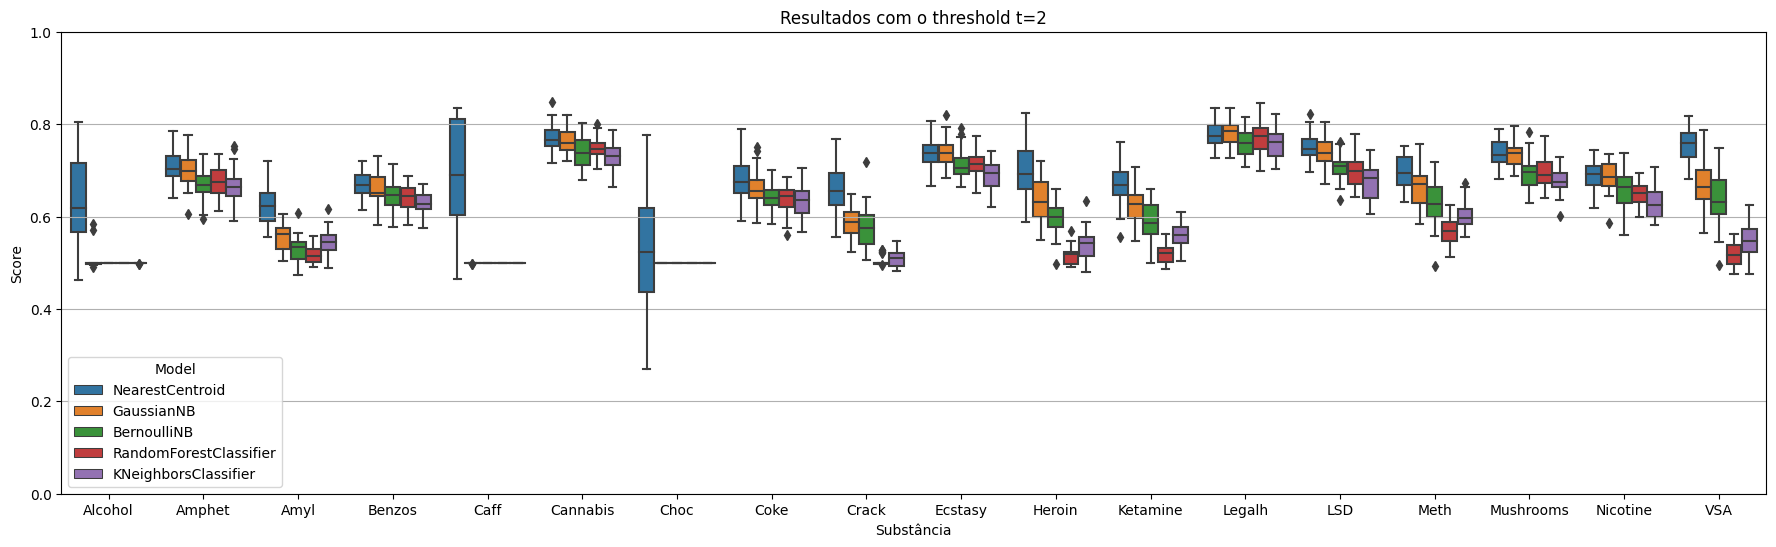

In [34]:
fig = ut.boxplot(results, f"Resultados com o threshold t={t}", refs=None, lims=(0, 1))
fig.savefig("figures/common.svg")
ut.show_statistics(results)

### Confusion Matrices

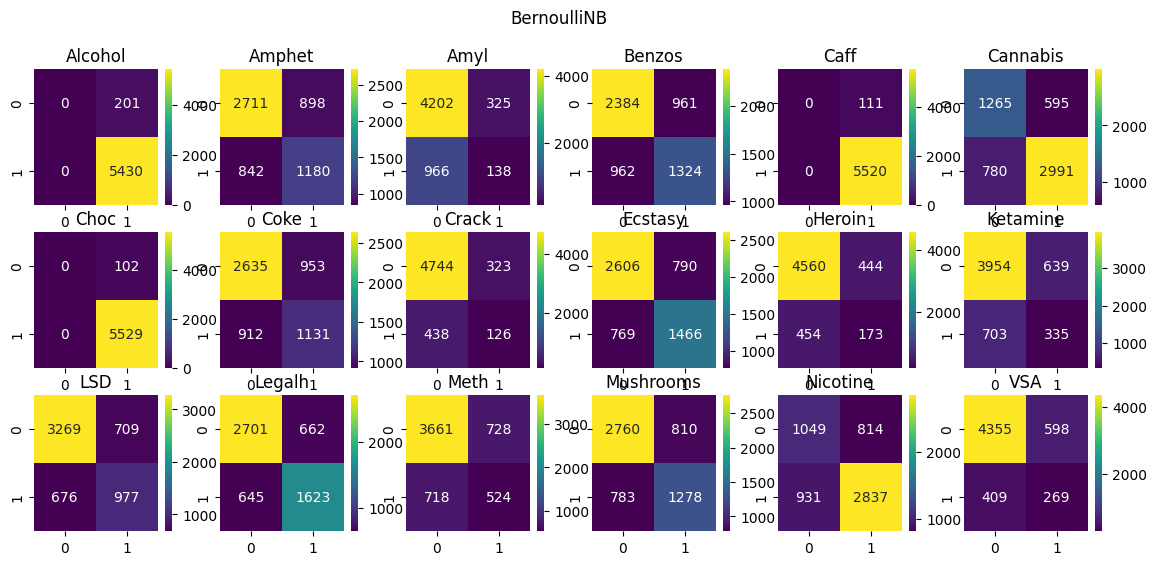

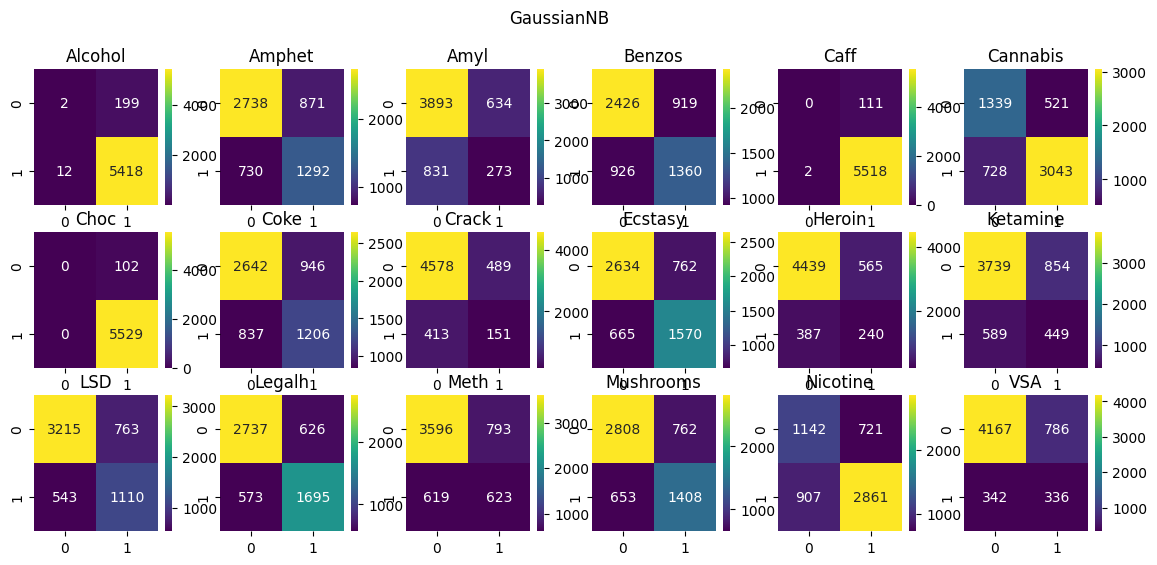

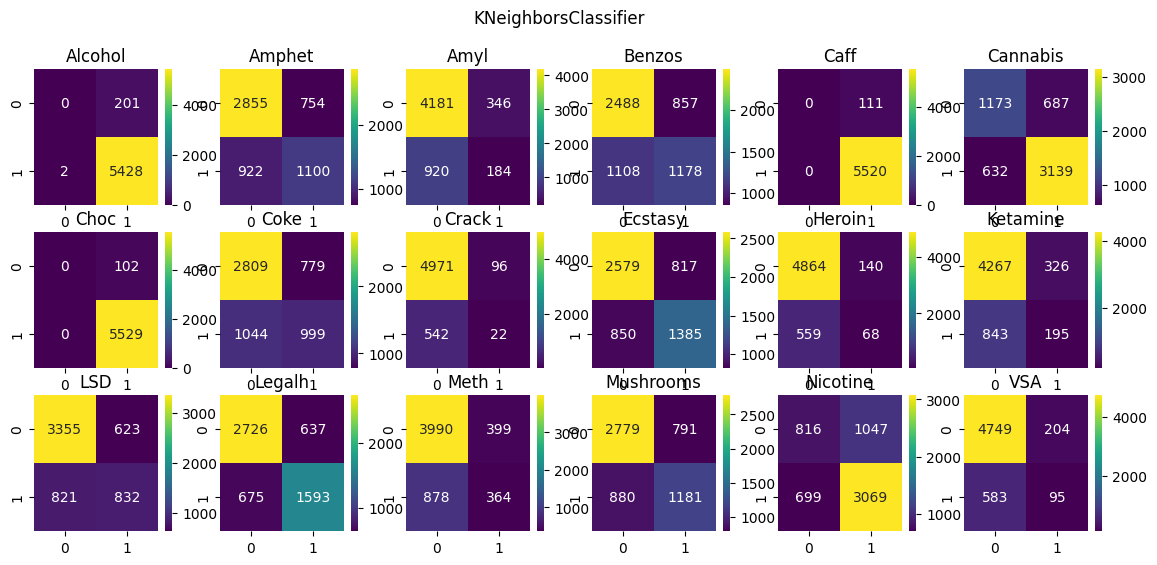

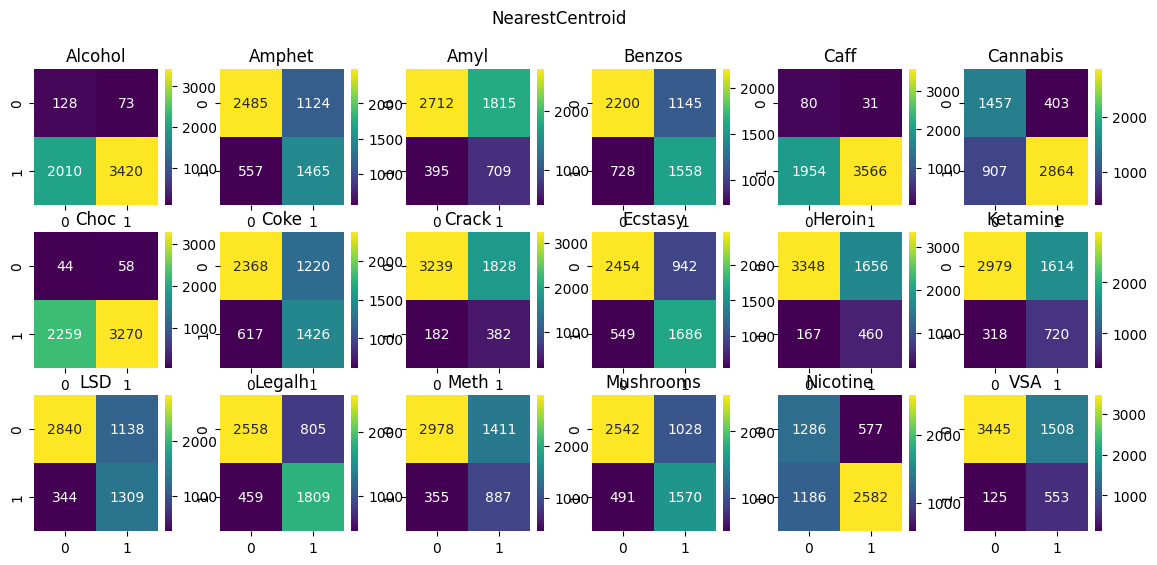

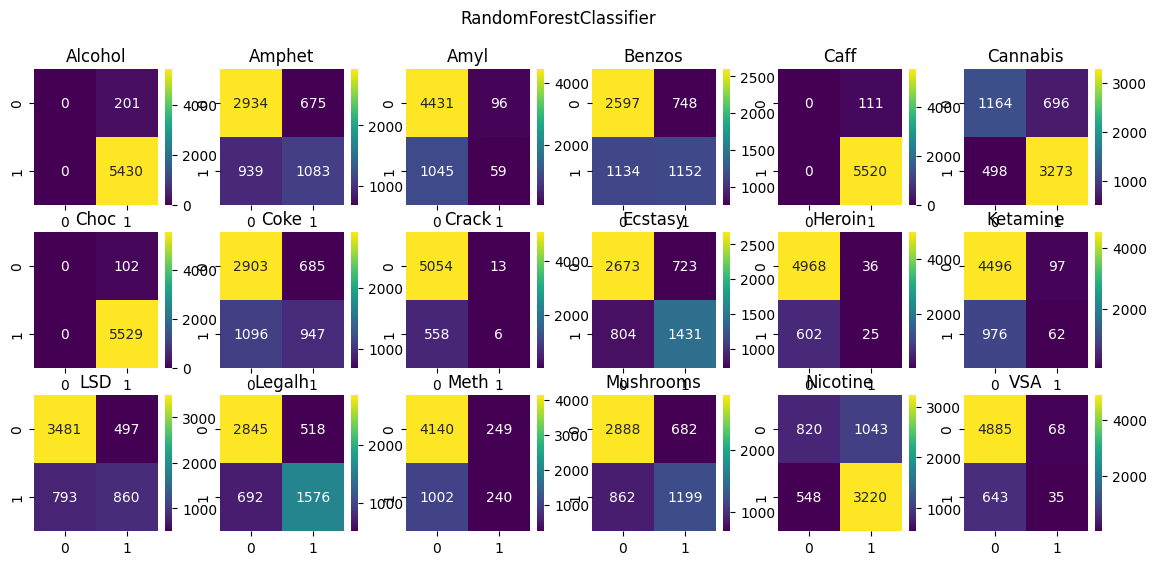

In [31]:
ut.confusion(cm)